In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import plot_df, plot_columns, chart_price, plot
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

31792.794214010904

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 02:06:00,2844.50,2853.75,2844.50,2853.00,8027,28331
1,2019-04-01 04:28:00,2853.25,2858.50,2853.25,2858.25,10196,36126
2,2019-04-01 09:01:00,2858.25,2860.00,2854.50,2855.75,9729,32537
3,2019-04-01 10:38:00,2855.50,2861.25,2854.75,2860.75,7007,32240
4,2019-04-01 13:04:00,2860.50,2861.00,2854.50,2856.25,6979,31874
...,...,...,...,...,...,...,...
4673,2019-09-05 03:39:00,2943.75,2962.50,2943.50,2960.75,9777,37426
4674,2019-09-05 04:06:00,2960.75,2969.00,2958.50,2969.00,7806,32773
4675,2019-09-05 05:27:00,2968.75,2971.75,2965.50,2967.50,7905,32697


In [6]:
data = pd.DataFrame({'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
data

,close,max,min,mid
label,,,,
0,2853.00,NaN,NaN,NaN
1,2858.25,NaN,NaN,NaN
2,2855.75,NaN,NaN,NaN
3,2860.75,NaN,NaN,NaN
4,2856.25,NaN,NaN,NaN
...,...,...,...,...
4673,2960.75,2960.75,2894.25,2927.500
4674,2969.00,2969.00,2894.25,2931.625
4675,2967.50,2969.00,2894.25,2931.625


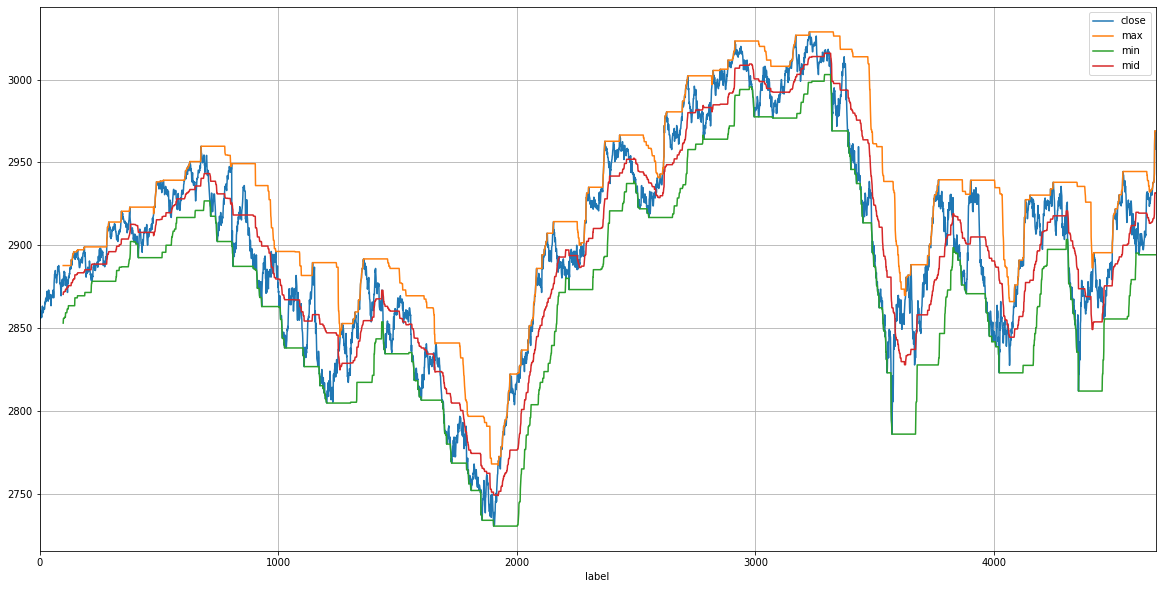

In [7]:
data.plot(figsize=(20,10), grid=True);

In [8]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()

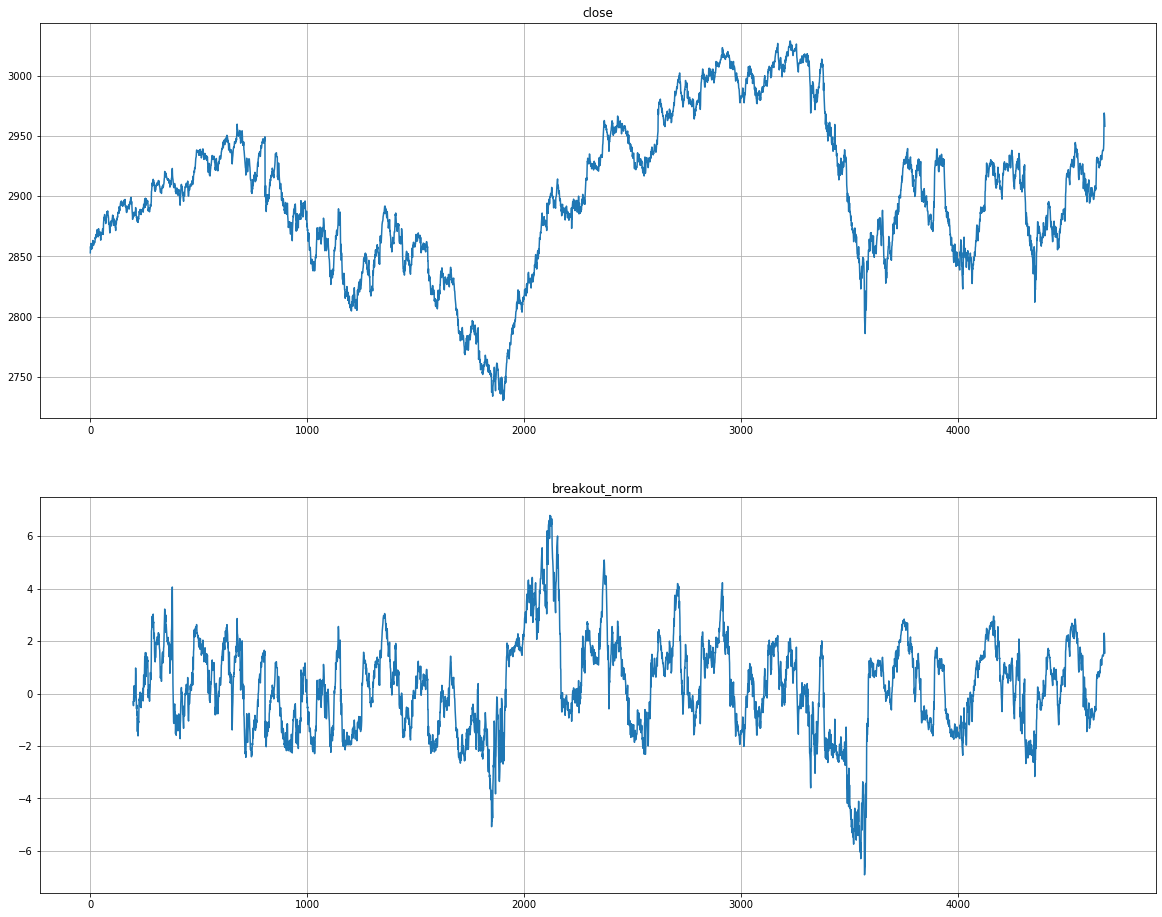

In [9]:
plot_df(data[['close', 'breakout_norm']])

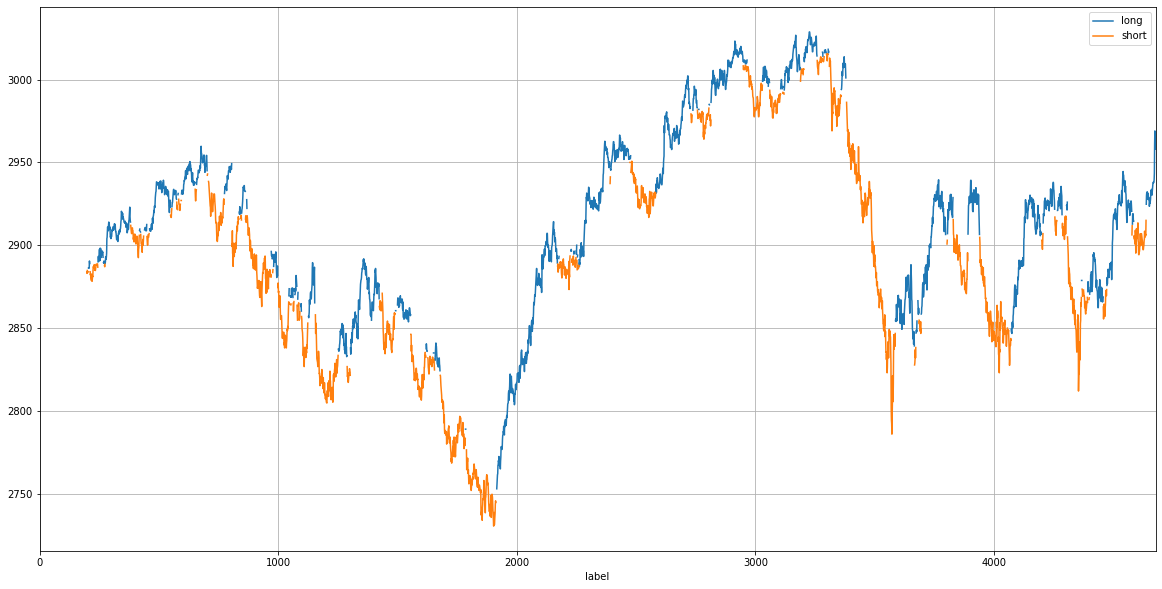

In [10]:
chart_price(data.close, data.breakout_norm)

In [13]:
plot('dupa')

ValueError: Arguments must be Series or Dataframe